# Logistic regression, posterior predictive distributions $p(x_n | x_{n-1}, D)$ and $p(x_{n-1} | x_{n}, D')$ 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [133]:
from bayesian import BayesianThreeFCLayers, prepare_simple_1d_time_series
from generate_time_series import load_logistic_map_time_series

To generate the predictive distributions used here, run
```
!python bayesian.py
```
Source code for the learning is [on Github](https://github.com/mathymess/reversibility-of-processes/blob/main/bayesian.py).
I set up a BNN and draw 100 samples from $p(x_n | x_{n-1}, D)$ (forward) and from $p(x_{n-1} | x_{n}, D')$ (backward) using MCMC (Markov Chain Monte Carlo).
window_len=1.

## Forward $p(x_n | x_{n-1}, D)$

In [86]:
pred_f = torch.load("20230724_preds/logistics3/predictive.forward.torch")

In [87]:
x_test_f = torch.linspace(-0.2, 1.2, 1000)
y_test_f = (4.0 * x_test_f * (1 - x_test_f))
print(x_test_f.shape, y_test_f.shape)

torch.Size([1000]) torch.Size([1000])


In [88]:
pred_f_obs = pred_f(x_test_f.reshape(-1, 1))["obs"]
print(pred_f_obs.shape)

torch.Size([100, 1000])


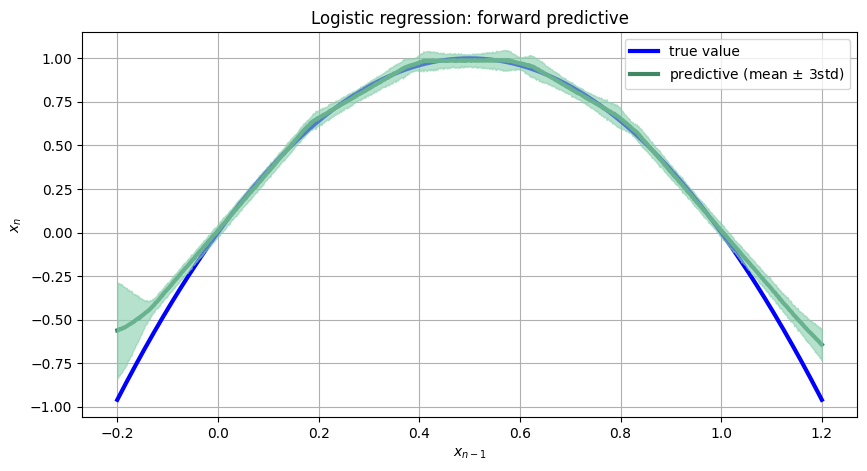

In [90]:
y_pred = pred_f_obs.mean(axis=0)
y_std = pred_f_obs.std(axis=0)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x_test_f, y_test_f, 'b-', linewidth=3, label="true value")
ax.plot(x_test_f, y_pred, '-', linewidth=3, color="#408765", label="predictive (mean $\pm$ 3std)")
ax.fill_between(x_test_f, y_pred - 3 * y_std, y_pred + 3 * y_std, alpha=0.6, color='#86cfac', zorder=5)

plt.xlabel("$x_{n-1}$")
plt.ylabel("$x_n$")
plt.title("Logistic regression: forward predictive")
plt.grid()
plt.legend()

plt.show()

## Backward $p(x_{n-1} | x_n, D')$

In [91]:
pred_b = torch.load("20230724_preds/logistics3/predictive.backward.torch")

In [92]:
x_test_b = torch.linspace(-0.2, 1.0, 1000)
y_test_b1 = 0.5 * (1 - torch.sqrt(1 - x_test_b))
y_test_b2 = 0.5 * (1 + torch.sqrt(1 - x_test_b))
print(x_test_b.shape, y_test_b1.shape, y_test_b2.shape)

torch.Size([1000]) torch.Size([1000]) torch.Size([1000])


In [93]:
pred_b_obs = pred_b(x_test_b.reshape(-1, 1))["obs"]
print(pred_b_obs.shape)

torch.Size([100, 1000])


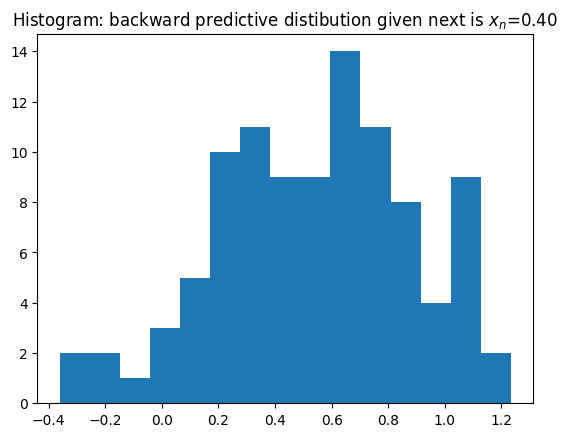

In [94]:
x_cross_section_index = 500
plt.hist(pred_b_obs[..., x_cross_section_index], bins=15)
plt.title(r"Histogram: backward predictive distibution given next is $x_{n}$"
          f"={x_test_b[x_cross_section_index]:.02f}")
plt.show()

### In the histogram above I would expect a bimodal distribution, since the quadratic equation $x_n = ax_{n-1}(1-x_{n-1})$ has two roots. But it doesn't happen!

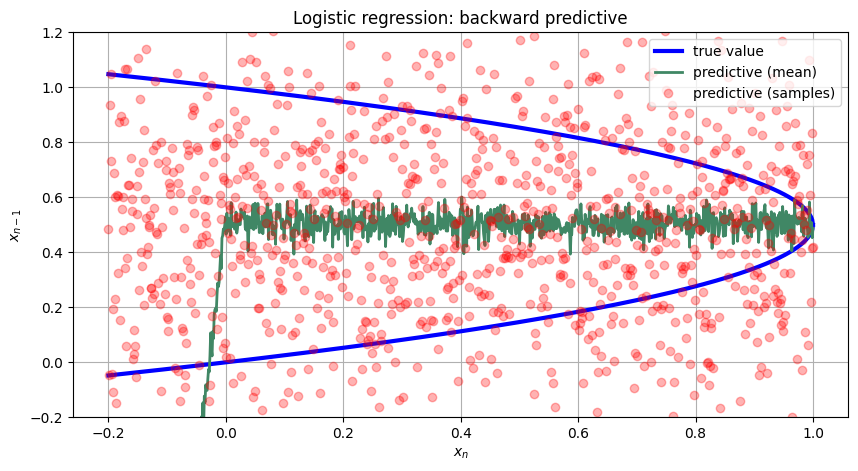

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x_test_b, y_test_b1, 'b-', linewidth=3, label="true value")
ax.plot(x_test_b, y_test_b2, 'b-', linewidth=3)

ax.plot(x_test_b, pred_b_obs.mean(axis=0), '-', color="#408765", linewidth=2, label="predictive (mean)")

ax.plot(x_test_b, pred_b_obs[0], "ro", alpha=0.3, label="predictive (samples)")

plt.xlabel("$x_{n}$")
plt.ylabel("$x_{n-1}$")
plt.ylim(-0.2, 1.2)
plt.title("Logistic regression: backward predictive")
plt.grid()
plt.legend()

plt.show()

In [12]:
((targets - preds_f.mean(axis=0)) ** 2).mean()


torch.nn.MSELoss()(p_f(x_test)["obs"].mean(axis=0), (4.0 * x_test * (1 - x_test)).squeeze())

tensor(1.3318)

## Same but window_len=2. Forward $p(x_n | x_{n-1}, x_{n-2}, D)$

In [101]:
pred_f = torch.load("20230724_preds/logistics2/predictive.forward.torch")

In [115]:
x1_test_f = torch.linspace(0, 1., 1000)
x2_test_f = (4.0 * x1_test_f * (1 - x1_test_f))
y_test_f = (4.0 * x2_test_f * (1 - x2_test_f))
x_test_f = torch.cat((x1_test_f.unsqueeze(1), x2_test_f.unsqueeze(1)), 1)
print(x_test_f.shape, y_test_f.shape)
assert torch.equal(x_test_f[..., 0], x1_test_f) and torch.equal(x_test_f[..., 1], x2_test_f)

torch.Size([1000, 2]) torch.Size([1000])


In [116]:
pred_f_obs = pred_f(x_test_f)["obs"]
print(pred_f_obs.shape)

torch.Size([100, 1000])


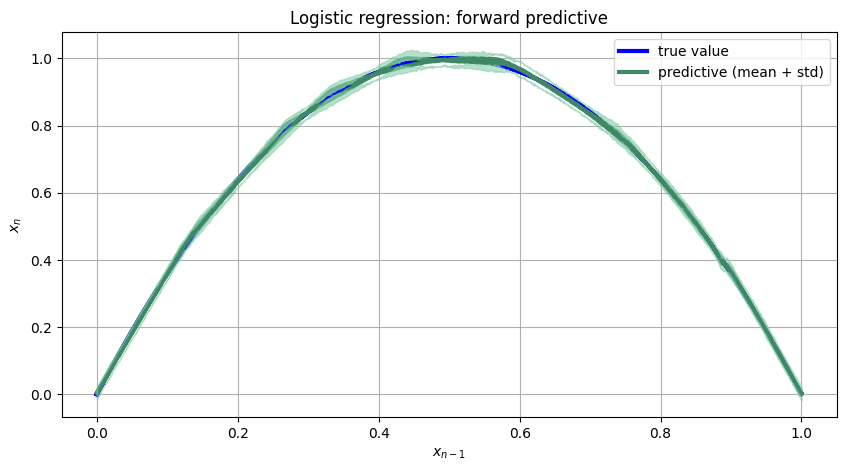

In [117]:
y_pred = pred_f_obs.mean(axis=0)
y_std = pred_f_obs.std(axis=0)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x2_test_f, y_test_f, 'b-', linewidth=3, label="true value")
ax.plot(x2_test_f, y_pred, '-', linewidth=3, color="#408765", label="predictive (mean + std)")
ax.fill_between(x2_test_f, y_pred - 3 * y_std, y_pred + 3 * y_std, alpha=0.6, color='#86cfac', zorder=5)

plt.xlabel("$x_{n-1}$")
plt.ylabel("$x_n$")
plt.title("Logistic regression: forward predictive")
plt.grid()
plt.legend()

plt.show()

## window_len=2. Backward $p(x_{n-2} | x_{n}, x_{n-1}, D')$

In [141]:
pred_b = torch.load("20230724_preds/logistics2/predictive.backward.torch")

In [142]:
x_test_b, y_test_b = prepare_simple_1d_time_series(load_logistic_map_time_series(1000), window_len=2, reverse=True)

In [143]:
pred_b_obs = pred_b(x_test_b)["obs"]
print(pred_b_obs.shape)

torch.Size([100, 998])


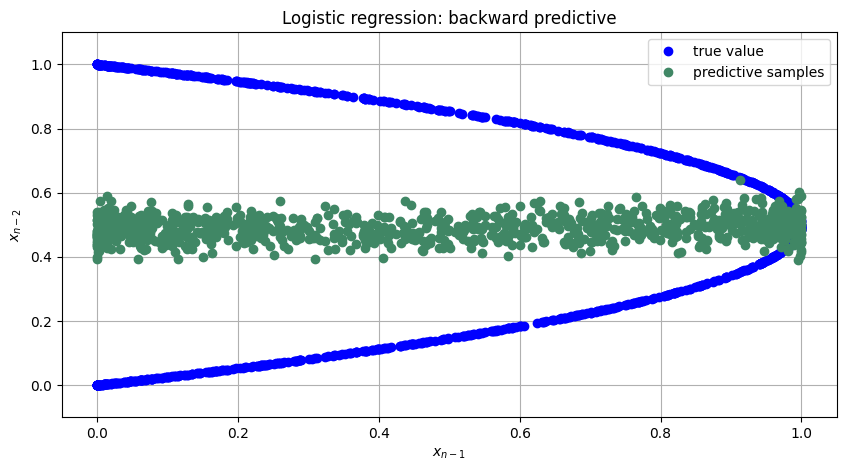

In [149]:
y_pred = pred_b_obs.mean(axis=0)
y_std = pred_b_obs.std(axis=0)
 
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x_test_b[..., 1], y_test_b, 'bo', linewidth=3, label="true value")
ax.plot(x_test_b[..., 1], y_pred, 'o', linewidth=3, color="#408765", label="predictive samples")
# ax.fill_between(x_test_b[..., 1], y_pred - 3 * y_std, y_pred + 3 * y_std, alpha=0.6, color='#86cfac', zorder=5)

plt.xlabel("$x_{n-1}$")
plt.ylabel("$x_{n-2}$")
plt.ylim(-0.1, 1.1)
plt.title("Logistic regression: backward predictive")
plt.grid()
plt.legend()

plt.show()